In [4]:
import requests, zipfile
import io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

#### 決定係数について
LinearRegressionのscoreはいわゆる$R^2$ 決定係数を指す  
$1 - \frac{\sum^{n}_{i=1}(y_i - \hat{y_i})}{\sum^{n}_{i=1}(y_i - \bar{y_i)}}, where  \bar{y}: 平均$

In [21]:
def R_score(y, y_pred):
    y_mean = y.mean()
    return 1 - ((y - y_pred)**2).sum() / ((y - y_mean)**2).sum()    

In [22]:
R_score(y_train, lr.predict(X_train))

0.7333575683901379

#### 対数尤度について  
対数尤度は誤差分布に正規分布を仮定した線形回帰、その尤度の対数をとったもである。具体的には下記を仮定している。  
$y_i = N(\sum_{i}^{N} w_i x_i, \sigma^2)$  
$\Pi_{i}^{N} \frac{1}{\sqrt{2 \pi \sigma^{2}}} exp(\frac{\epsilon^{2}}{2 \sigma^{2}})$  
上記の対数をとったものが対数尤度となる  
$l = \frac{N}{2}\log(2\pi\sigma^{2}) - \frac{1}{2 \sigma^{2}} \sum^{N}_{i=1} \epsilon^{2}$

In [23]:
def likelihood(y, y_pred):
    error = y - y_pred
    v = error.var()
    return np.prod(1 / np.sqrt(2*np.pi*v)*np.exp((error**2)/(2*v)))

In [24]:
def log_likelihood(y, y_pred):
    error = y - y_pred
    v = error.var()
    N = len(error)
    return -N / 2 * np.log(2*np.pi*v) - 1 /(2*v)*np.sum(error**2)

In [25]:
log_likelihood(y_train, lr.predict(X_train))

-958.3271768599877

#### AIC
AICは残渣誤差（対数尤度の２倍）に変数の自由度を加味したもの。  
回帰モデルは少ない変数で目的変数を説明できるほど良いモデルである、という思想を指標化したものである  
$AIC = -2 \times log-Likelihood + 2 \times (パラメータ数 + 1)$  
上記のAICが小さいほど良いモデルとして評価する

In [26]:
def AIC(y, y_pred, X):
    params = X.shape[1]
    L =  log_likelihood(y, y_pred)
    return -2 * L + 2 * (params+1)

#### BIC
尤度に対して罰則項としてパラメータ数およびデータ数を与えたもの  
AIC同様小さいほど良いモデルとして評価  
$BIC = -2 \times log-likelihood + (パラメータ数+1) log(データ数)$

In [27]:
def BIC(y, y_pred, X):
    N, params = X.shape
    L =  log_likelihood(y, y_pred)
    return -2 * L + (params+1) * np.log(N)

In [29]:
BIC(y_train, lr.predict(X_train), X_train)

1935.034833120514

#### 変数増加法  
重要度の高い変数から順番に追加、増減はさせない

In [169]:
auto = pd.read_csv("./automobile.csv")
auto = auto.replace("?", np.nan).dropna()

In [170]:
numberList = ['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height',
                'curb-weight', 'engine-size', 'bore', 'stroke', 'compression-ratio',
                'horsepower','peak-rpm', 'city-mpg', 'highway-mpg', 'price']

In [171]:
for column in numberList:
    auto[column] = pd.to_numeric(auto[column], errors='coerce')

In [172]:
auto = auto[numberList]

In [173]:
X = auto.drop('price', axis=1)
y = auto['price']

In [174]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [187]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [188]:
lr = LinearRegression()

In [271]:
from sklearn.metrics import mean_squared_error
def stepwiseFW(X, y, X_test, y_test):
    lr = LinearRegression()
    scores = np.array([])
    aics = np.array([])
    errors = []
    for i in range( X.shape[1]):
        x = X[:,i].reshape(-1,1)
        fit = lr.fit(x, y)
        scores = np.append(scores, fit.score(x, y))
        aics = np.append(aics, AIC(y, fit.predict(x), x))
    indexs = scores.argmax()
    indexsBuf = np.argsort(-scores)[1:]
    aic = aics[indexs]
    fit = lr.fit(X[:, indexs].reshape(-1,1), y)
    error = mean_squared_error(y_true=y_test, y_pred=fit.predict(X_test[:, indexs].reshape(-1,1)))
    errors.append({str(indexs): error})   

    flag = True
    while flag:
        flag= False
        for j, jdx in enumerate(indexsBuf):
            indexs = np.append(indexs, jdx)
            fit = lr.fit(X[:,indexs], y)
            y_pred = fit.predict(X[:, indexs])
            aic_temp = AIC(y, y_pred, X[:, indexs])
            if aic_temp > aic:
                indexs = np.delete(indexs, -1) #先ほど追加したindexを削除
            else:
                aic = aic_temp
                indexsBuf = np.delete(indexsBuf, j) # このindexを採択するため、バッファーから削除
                flag = True # このfor loopでパラメータを見つけたため、while継続
                temp = list(indexs)
                temp = list(map(str, temp))
                temp = ",".join(temp)
                error = mean_squared_error(y_true=y_test, y_pred=fit.predict(X_test[:, indexs]))
                errors.append({temp: error})
                break
    return indexs , errors

In [585]:
import copy
class Stepwise():
    
    def __init__(self, X_train, y_train, mode="FWBW", evaluation="AIC"):
        self.mode = mode
        self.lr = LinearRegression()
        self.scores, self.evals, self.errors, self.preds, self.idx, self.coef, self.intercept = [], [], [], [], [], [],[]
        self.params_num, self.eval_best = 0, 0
        self.index_best = []
        self.X_train, self.y_train, self.X_test, self.y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
        if evaluation == "BIC":
            self.eval = BIC
        else:
            self.eval = AIC
        
    def run(self):
        indexs = self.run_1st()
        if self.mode=="FWBW":
            self.stepwiseFWBW(indexs)
        else:
            self.stepwiseFW(indexs)
        
    def run_1st(self):
        self.params_num = X.shape[1]
        for i in range(self.params_num):
            x = self.X_train[:,i].reshape(-1,1)
            self.core(x, y_train)
            self.idx.append([i])
            
        self.index_best.append(np.array(self.scores).argmax())
        self.eval_best = self.evals[self.index_best[0]]
        indexs = list(np.argsort(-np.array(self.scores)))
        self.sort(indexs)
        indexs = indexs[1:]
        return indexs
    
    def stepwiseFWBW(self, indexs):
        flag = True
        while flag:
            flag= False
            j_best_temp, jdx_best_temp = 0, 0
            for j, jdx in enumerate(indexs):
                self.index_best.append(jdx)
                self.core(X[:,self.index_best], y)
                self.idx.append( copy.deepcopy(self.index_best))
                del self.index_best[-1]
                if self.evals[-1] >= self.eval_best:
                    pass
                else:
                    self.eval_best = self.evals[-1]
                    j_best_temp = j
                    jdx_best_temp = jdx
                    flag = True # このfor loopでパラメータを見つけたため、while継続
            
            if flag:
                del indexs[j_best_temp]
                self.index_best.append(jdx_best_temp)

                    
    def stepwiseFW(self, indexs):
        flag = True
        while flag:
            flag= False
            for j, jdx in enumerate(indexs):
                self.index_best.append(jdx)
                self.core(X[:,self.index_best], y)
                self.idx.append( copy.deepcopy(self.index_best))
                if self.evals[-1] >= self.eval_best:
                    del self.index_best[-1]
                else:
                    self.eval_best = self.evals[-1]
                    del indexs[j]
                    flag = True # このfor loopでパラメータを見つけたため、while継続
                    break
        
    def core(self, X, y):
        XT = self.translateRank(X)
        fit = lr.fit(XT, y)
        y_pred = fit.predict(XT)
        self.evals.append(self.eval(y, y_pred, XT))
#         self.evals.append(AIC(y, y_pred, XT))
        self.preds.append(y_pred)
        self.scores.append(fit.score(XT, y))
        self.coef.append(fit.coef_)
        self.intercept.append(fit.intercept_)
        
    def mse(self, X, y):
        X = np.array(X)
        y = np.array(y)
        for i, co, inter in zip(self.idx, self.coef, self.intercept):
            y_pred = np.dot(X[:, i], co) + inter
            self.errors.append(mean_squared_error(y, y_pred))

    def translateRank(self, x):
        if x.ndim == 1:
            return x.reshape(-1,1)
        else:
            return x
        
    def sort(self, idx):
        self.evals = self.listGetter(self.evals, idx)
        self.preds = self.listGetter(self.preds, idx)
        self.scores = self.listGetter(self.scores, idx)
#         self.errors = listGetter(self.errors, idx)
        self.coef = self.listGetter(self.coef, idx)
        self.intercept = self.listGetter(self.intercept, idx)
        self.idx = self.listGetter(self.idx, idx)
    
    def listGetter(self, l, idx):
        return [l[i] for i in idx  ]

In [586]:
sw1 = Stepwise(X_train, y_train, "FW", "BIC")
sw1.run()
sw1.mse(X_test, y_test)
sw2 = Stepwise(X_train, y_train, "FWBW", "BIC")
sw2.run()
sw2.mse(X_test, y_test)

In [591]:
print(np.array(sw1.errors).argmin())
print(np.array(sw2.errors).argmin())

0
24


In [592]:
sw2.idx[24]

[6, 1]

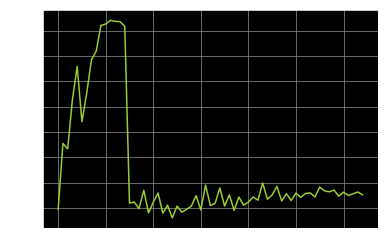

In [593]:
plt.plot(np.log(sw2.errors))

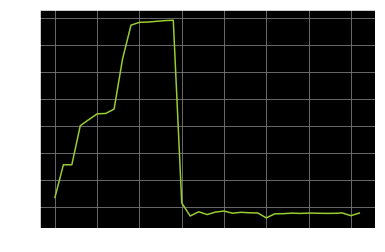

In [595]:
plt.plot(sw1.evals)